####  On the first run, specify inputs labelled by ###, mainly  
dir_path and filename

If directly processing from .tif, specify mask calibraiton etc as usual

####  Later can tune parameters, eg

feature_2_args 'targets' : [0.075]

feature_3_args 'angle_roi'

feature_4_args 'fit_range'

In [25]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-
import time, os, sys, re, glob, random, copy
import numpy as np
import matplotlib.pyplot as plt
from fun_map import *
from fun_gui import *
mpl.rcParams['font.size'] = 10
mpl.rcParams['figure.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 2 
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

########## Input 
dir_path = '/home/etsai/BNL/Users/SMI/CMurray/2019C1/saxs/' ###
feature_args = {
                'source_dir': dir_path,
                'filename'  : 'M-coarse-3_KE_G23G1_35nmDiR*', ###
                'filename'  : 'M-coarse1_KE_G23G1_15nmDiR_10mg-36_WAXS13.85deg',
                'filename'  : 'M-fine1_KE_G23G1_15nmDiR_10mg-36_WAXS13.85deg',
                'exclude': [], 
                'direct': 0,  ###
                'feature_id': 1, 
                'map_type': 'xy',
                'log10'  : 0, 
                'verbose': 1,
                'plot_interp':  [None, 0.001], #None, 'linear', 'cubic', 'nearest', pixel in mm
                'subplot': -1 #<=0 when jupyter, TEMP SOL
               } 

feature_1_args = {'source_dir' : dir_path+'analysis/qr_image/', 'ext' : '.npz',
             'protocols': [Protocols.qr_image()], 
             'targets' : [],       # [[190, 43], [123, 123]]
             'roi': [1, 'mean'],   # [*] Choose +/- n pixels to include
             }

feature_2_args = {'source_dir' : dir_path+'analysis/circular_average/', 'ext' : '.dat', 'data_col' : [0, 2],
             'protocols': [Protocols.circular_average()], 
             'targets' : [0.016, 0.072],  ### q
             'roi': [3, 'mean'],   # [*] Choose the half-width (data points) of the peak q
             'N_peaks_find': 7
             }
                   
feature_3_args = {'source_dir' : dir_path+'analysis/linecut_angle124/', 'ext' : '.dat', 'data_col' : [0, 1],
             'protocols': [Protocols.linecut_angle(q0=np.asarray(feature_2_args['targets']), dq=0.002)], 
             'angle_roi': [6, 'mean'], #[-61,  1], # range [0, 60] or N_fold [6, 'mean']
             'targets': ['argmax','var'],            #['argmax','var'], #[6.6, 9.5, 12.6,32, 35, 49]
             'normalize': True,        # normalize by sum(I)
             'N_peaks_find': 10,
             }

feature_4_args = {'source_dir' : dir_path+'analysis/circular_average/', 'ext' : '.dat', 'data_col' : [0, 2],
             'protocols': [Protocols.circular_average()], 
             'fit_range': 0.122 + np.asarray([-0.01, 0.01]),  
             'chi2_thr': 0.001,        # only consider pixels above this threshold
             'targets': ['b', 'prefactor1', 'x_center1', 'd_spacing_nm', 'grain_size_nm', 'chi2'] #b, prefactor1, x_center1, sigma1, chi2
             }

feature_args.update(feature_1_args=feature_1_args, feature_2_args=feature_2_args, feature_3_args=feature_3_args, feature_4_args=feature_4_args)


# =============================================================================
# The usual: calibration, mask, and process args
# =============================================================================
calibration = Calibration(wavelength_A=0.770088) # 16.1 keV
calibration.set_image_size(981, height=1043) # Pilatus1M
calibration.set_pixel_size(pixel_size_um=172.0)

mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
mask = Mask(mask_dir+'Dectris/Pilatus1M_main_gaps-mask.png')
filename = feature_args['filename']
if 1:
    calibration.set_distance(5.999)
    calibration.set_beam_position(347.0, 1043-141.0)
    mask.load(dir_path+'analysis/Pilatus1M_current-mask_0321.png')

load_args = { 'calibration' : calibration,
             'mask' : mask,
             }
run_args = { 'verbosity' : 0,
            'plot_save': False,
            'threshold': 65000
            }
process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)
#if feature_args['direct']:
feature_args['process'] = process
    
# =============================================================================
# Find matching files
# =============================================================================
infiles, match_re = get_filematch(feature_args)  


M-fine1_KE_G23G1_15nmDiR_10mg-36_WAXS13.85deg*.npz
Considering 1200 files...
  - Now considering 1200 files...


M-fine1_KE_G23G1_15nmDiR_10mg-36_WAXS13.85deg*.dat


<IPython.core.display.Javascript object>


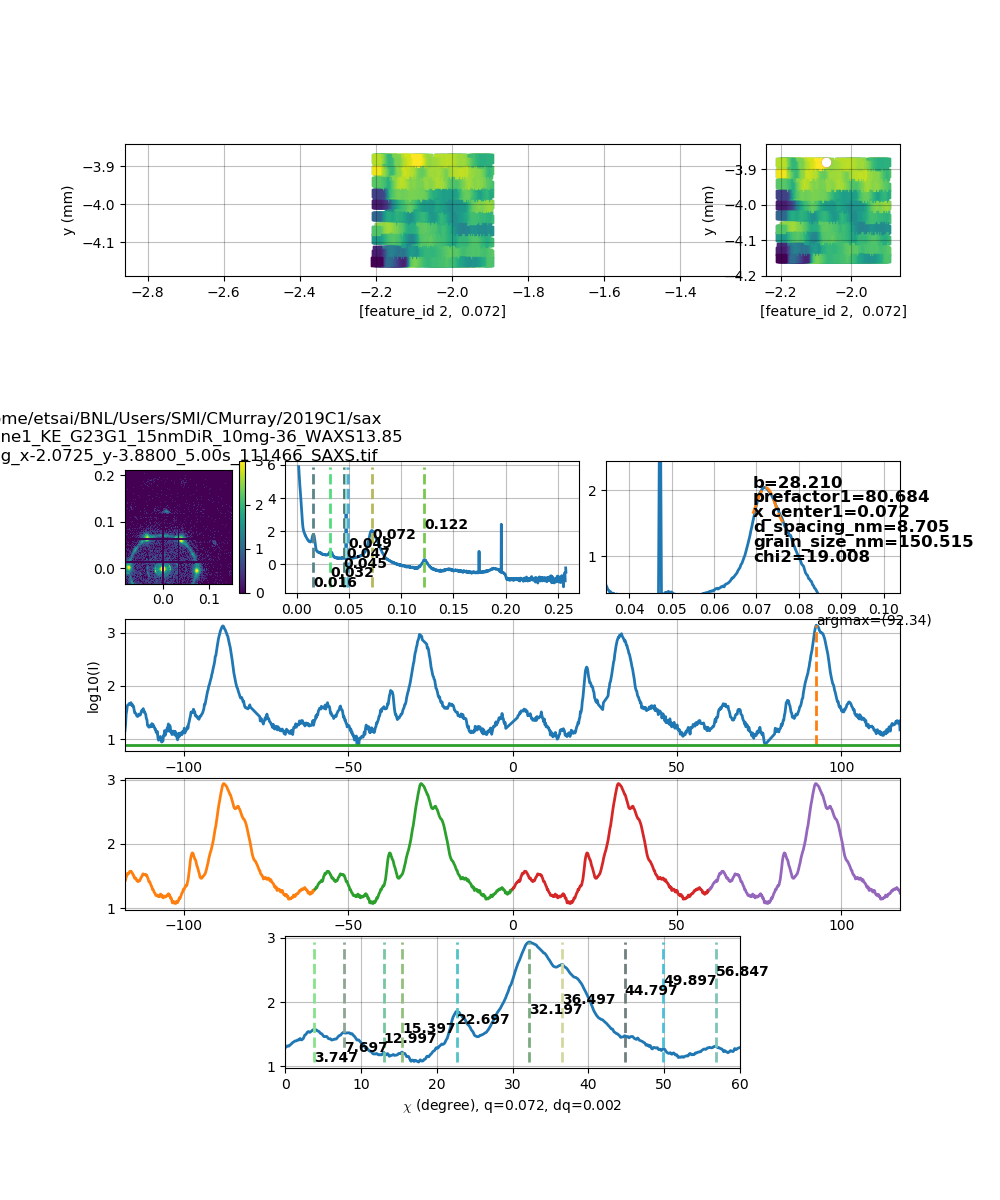

In [30]:
# =============================================================================
# Given x,y and a list of data positions, find the closest point with data
# =============================================================================
def get_closest(pos, post_list):# pos_list is 2 by N
    r_min = 1e10;
    for idx, item in enumerate(post_list[0]):
        x = post_list[0][idx]
        y = post_list[1][idx]
        r = calc_distance(pos, [x, y])
        if r<r_min:
            r_min = r
            xf = x; yf = y
            #idxf = int(idx)
    return xf, yf

def calc_distance(p0, p1):
    r =  math.hypot(p0[0]-p1[0], p0[1]-p1[1])
    return r

# =============================================================================
# Click on map to show data
# =============================================================================
feature_args.update(feature_id = 2);
feature_args['direct'] = False  # temporary off, faster

infiles, match_re = get_filematch(feature_args) 
features_map = get_map(infiles, match_re, feature_args) 
x_pos = features_map['x_pos']
y_pos = features_map['y_pos']

%matplotlib nbagg
fig = plt.figure(20, figsize=[10,12]);  fdim = [6, 5]
axis_font = {'fontname':'Arial', 'size':'8', 'weight':'bold'}
cmap = plt.get_cmap('viridis');  feature_args.update(cmap=cmap)   
ax1 = plt.subplot2grid((fdim[0], fdim[1]), (0, 0), colspan=4); ax1.cla()
feature_args['plot_interp'] = [None, 1]
feature_args['subplot'] = 0
feature_args['val_stat'] = 'auto'
plot_map(features_map, **feature_args)

pos = []
feature_args['direct'] = True
def onclick(event):   
    
    xc = event.xdata; 
    yc = event.ydata 
    if event.inaxes!= ax1: return    
    xf, yf = get_closest([xc, yc], [x_pos, y_pos])
    
    ax2 = plt.subplot2grid((fdim[0], fdim[1]), (0, 4), colspan=1); ax2.cla()
    plot_map(features_map, **feature_args)
    plt.scatter(xc,yc,color='r') # clicked    
    plt.scatter(xf,yf,color='w') # position found in the data position list

    q_peak = 0.072 ### Choose the peak to plot I(chi) and do fitting
    N_fold = 6     ### Guess sym
    feature_ids = [1, 2, 4, 3, 3, 3]  # temporary solution for plotting
    feature_3_args.update(protocols=[Protocols.linecut_angle(q0=q_peak, dq=0.002)], angle_roi = [-180, 180])   
    feature_4_args.update(fit_range= q_peak + np.asarray([-0.003, 0.005]))
   
    feature_args.update(subplot=0, feature_1_args=feature_1_args, feature_2_args=feature_2_args, feature_3_args=feature_3_args, feature_4_args=feature_4_args)
    colidx = 0
    for idx, feature_id in enumerate(feature_ids):
        feature_args.update(feature_id=feature_id); 
        infiles = find_file(xf, yf, feature_args)
        
        colspan = 2 if feature_id>1 else 1
        if idx<=2:
            feature_args['val_stat'] = [0, 3]  ## Change color axis range
            ax2 = plt.subplot2grid((fdim[0], fdim[1]), (2, colidx), colspan=colspan); ax2.cla()
            colidx = colidx+colspan
        elif idx==3:
            ax2 = plt.subplot2grid((fdim[0], fdim[1]), (3, 0), colspan=fdim[1]); ax2.cla()
        elif idx==4: 
            ax2 = plt.subplot2grid((fdim[0], fdim[1]), (4, 0), colspan=fdim[1]); ax2.cla()
            feature_3_args.update(protocols=[Protocols.linecut_angle(q0=q_peak, dq=0.002)], angle_roi = [N_fold, 'mean'])
            feature_args.update(feature_3_args=feature_3_args, subplot=0)
        else:
            ax2 = plt.subplot2grid((fdim[0], fdim[1]), (5, 1), colspan=3); ax2.cla()
            feature_3_args.update(protocols=[Protocols.linecut_angle(q0=q_peak, dq=0.002)], angle_roi = [N_fold, 'mean'])
            feature_args.update(feature_3_args=feature_3_args)
            
        if feature_id==1:
            feature_args.update(verbose=1)
            feature_args.update(log10=1)
        else:
            feature_args.update(verbose=0)
            feature_args.update(log10=1)
            
        if infiles!=[]: 
            plot_data(infiles[0], **feature_args)
        feature_args.update(subplot=-1)
               
        
    
fig.canvas.mpl_connect('button_press_event', onclick)
fig.show()


M-fine1_KE_G23G1_15nmDiR_10mg-36_WAXS13.85deg*.tif


<IPython.core.display.Javascript object>


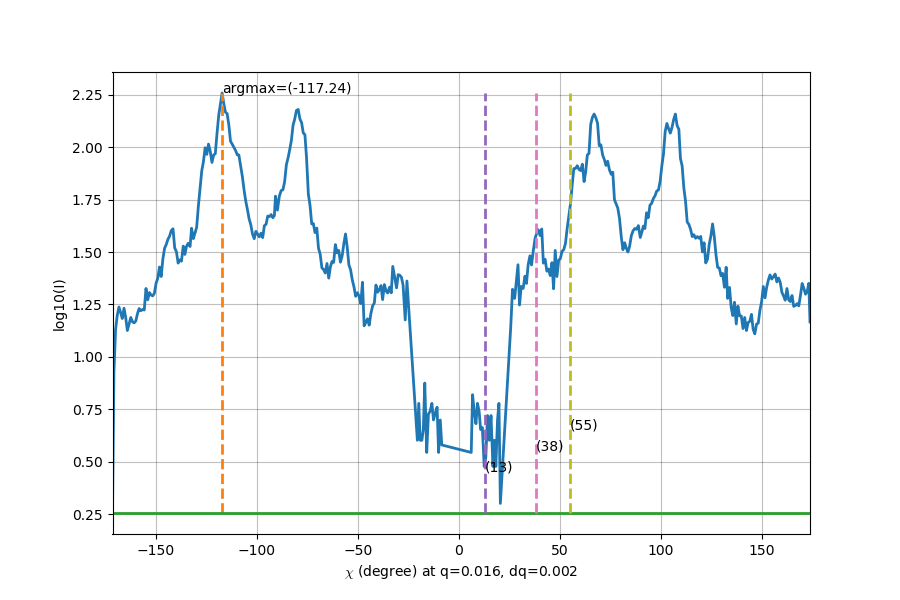

Running linecut_angle for M-fine1_KE_G23G1_15nmDiR_10mg-36_WAXS13.85deg_x-1.9023_y-4.0994_5.00s_112139_SAXS


In [23]:
## Plot one data 
feature_args.update(feature_id = 3); ### Choose 1-4
q_peak = 0.016  ### Choose the peak to plot I(chi) and do fitting
N_fold = 2      ### Guess sym

feature_3_args.update(protocols=[Protocols.linecut_angle(q0=q_peak, dq=0.002)], angle_roi = [-180, 180]) #[N_fold, 'mean'])

feature_4_args.update(fit_range= q_peak + np.asarray([-0.003, 0.005]))

infiles, match_re = get_filematch(feature_args) 
%matplotlib nbagg
fig = plt.figure(100, figsize=[9,6]); plt.clf()
cmap = plt.get_cmap('jet');   #viridis
feature_args.update(cmap=cmap)    
#feature_args.update(filename='*114693*');   infiles, match_re = get_filematch(feature_args)
feature_args.update(log10=1)
feature_args['val_stat'] =  'auto' # 'auto' ## coloraxis, eg [0, 1.5] or 'auto'
feature_args['subplot'] = -1
if infiles!=[]: 
    plot_data(infiles[0], **feature_args)
    

### Generate Map

Could take a while to generate map if using direct=1, be patient...

**The better way is to generate/save results then with direct=0 load/plot them

medium_G2-3G1_17mgml_*5.00s*.dat
Considering 809 files...
  - Now considering 800 files...
['/home/etsai/BNL/Users/SMI/CMurray/2018C3_CMurray_data/saxs/analysis/linecut_angle124/medium_G2-3G1_17mgml_x-0.000_y-6.600_5.00s_071209_SAXS.dat', '/home/etsai/BNL/Users/SMI/CMurray/2018C3_CMurray_data/saxs/analysis/linecut_angle124/medium_G2-3G1_17mgml_x-0.000_y-6.700_5.00s_071208_SAXS.dat', '/home/etsai/BNL/Users/SMI/CMurray/2018C3_CMurray_data/saxs/analysis/linecut_angle124/medium_G2-3G1_17mgml_x-0.000_y-6.900_5.00s_071206_SAXS.dat', '/home/etsai/BNL/Users/SMI/CMurray/2018C3_CMurray_data/saxs/analysis/linecut_angle124/medium_G2-3G1_17mgml_x-0.000_y-7.000_5.00s_071205_SAXS.dat', '/home/etsai/BNL/Users/SMI/CMurray/2018C3_CMurray_data/saxs/analysis/linecut_angle124/medium_G2-3G1_17mgml_x-0.000_y-7.100_5.00s_071204_SAXS.dat', '/home/etsai/BNL/Users/SMI/CMurray/2018C3_CMurray_data/saxs/analysis/linecut_angle124/medium_G2-3G1_17mgml_x-0.000_y-7.400_5.00s_071201_SAXS.dat', '/home/etsai/BNL/Users/SMI

----------------------
Total of 5 maps
Time = 84.4 s = 1.4 min
----------------------


<IPython.core.display.Javascript object>


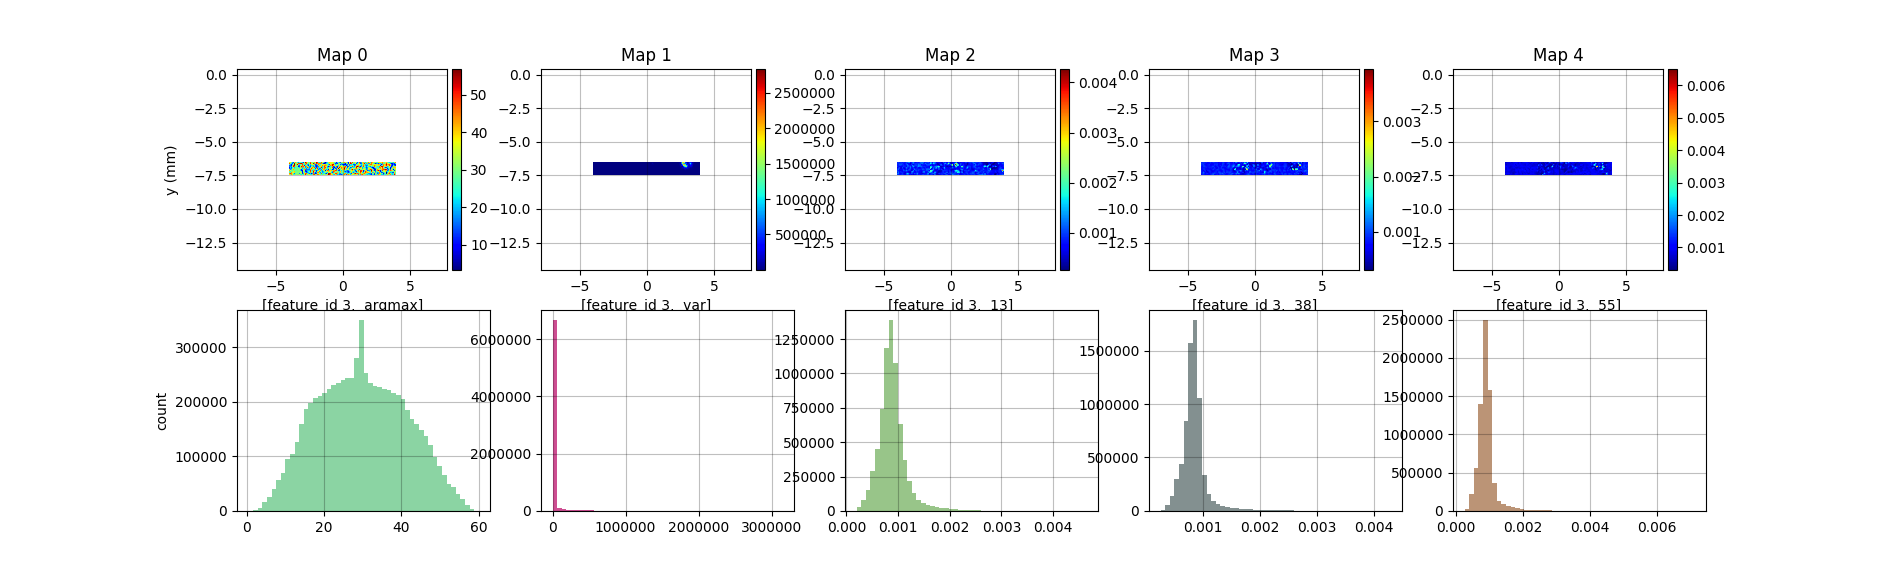

In [5]:
### Get_map
feature_ids = [3]  ### 
#feature_2_args['targets'] = [0.031, 0.05] ###
feature_3_args.update(protocols=[Protocols.linecut_angle(q0=0.125, dq=0.002)], angle_roi = [6, 'mean']) ###
feature_3_args['targets'] = ['argmax','var', 13, 38, 55] #['argmax','var']

feature_args.update(feature_3_args=feature_3_args)
feature_args['verbose'] = 1
feature_args['plot_interp'] =  ['linear', 0.001]
feature_args['subplot'] = 1
features_map_list = []; t0 = time.time()
for idx in feature_ids:
    feature_args['feature_id'] = idx; 
    
    ## Find matching files   
    infiles, match_re = get_filematch(feature_args)  
    print(infiles)
    
    ## Get map
    features_map = get_map(infiles, match_re, feature_args)
    features_map_list.append(features_map)
       
    
    t1 = time.time()-t0
    print('----------------------')
    print('Total of {} maps'.format(count_maps(features_map_list)))
    print('Time = {:.1f} s = {:.1f} min'.format(t1, t1/60))
    print('----------------------')
    
## Plot all maps
%matplotlib nbagg
fig = plt.figure(300, figsize=[10,6]); plt.clf()  
cmap = plt.get_cmap('jet');  feature_args.update(cmap=cmap)  
features_map_all = extract_maps(features_map_list) 
feature_args.update(log10=0)
plot_map(features_map_all, **feature_args)

# To access the first map: eg, feature_a = features_map_all['features'][0]

#### Overlay up to 3 channels for comparison

<IPython.core.display.Javascript object>


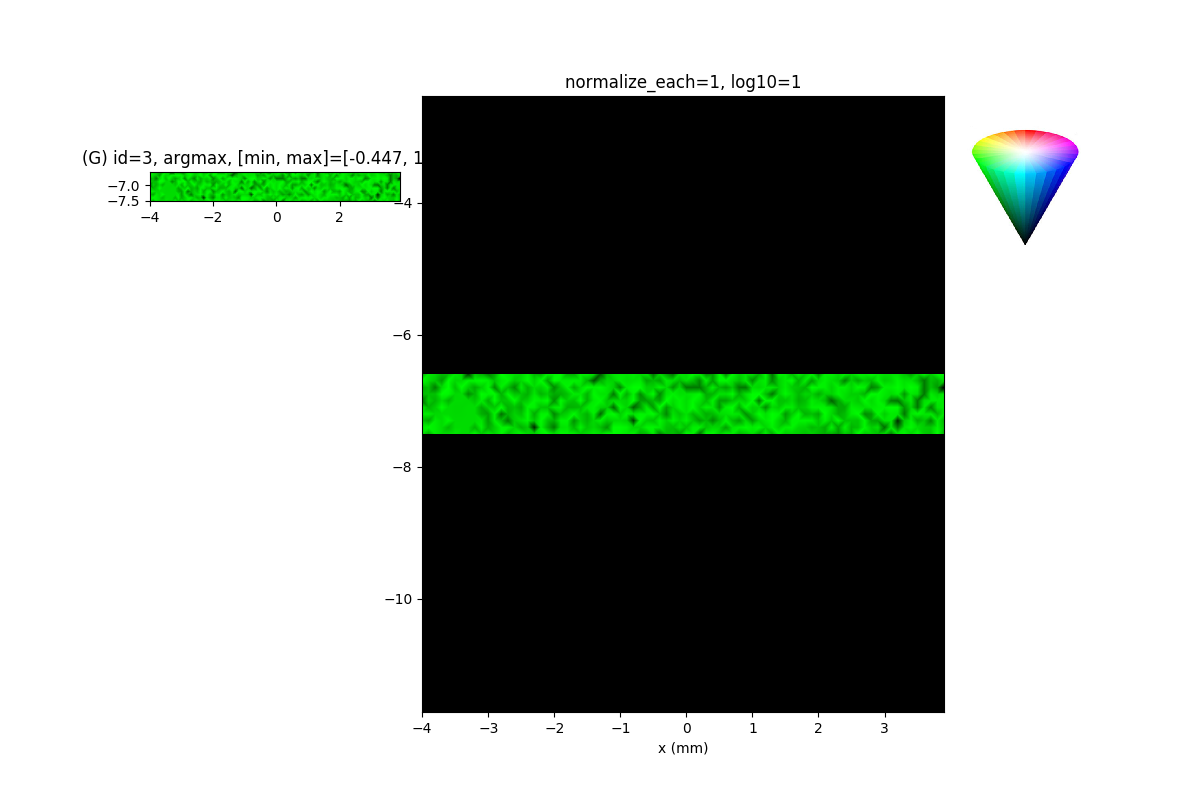

More then 3 features available, using only [0] for RGB


In [8]:
## Plot overlay of three maps (RGB)  
feature_args['overlay_rgb'] = [0]  ## Map index starts from 0
feature_args['rgb'] = 'G'           ## Up to three channels 'RGB'
feature_args['normalize_each'] = 1   ## Normalize each channel 
feature_args.update(log10=1)

fig = plt.figure(500, figsize=[12,8]); plt.clf()  
overlay = plot_overlay(features_map_list, **feature_args) 


In [129]:
features_map_all
#infiles[0]



{'x_pos': [-2.98], 'y_pos': [-6.629], 'features': [], 'ids': [], 'tags': []}

#### Stuffs, might be useful

<IPython.core.display.Javascript object>


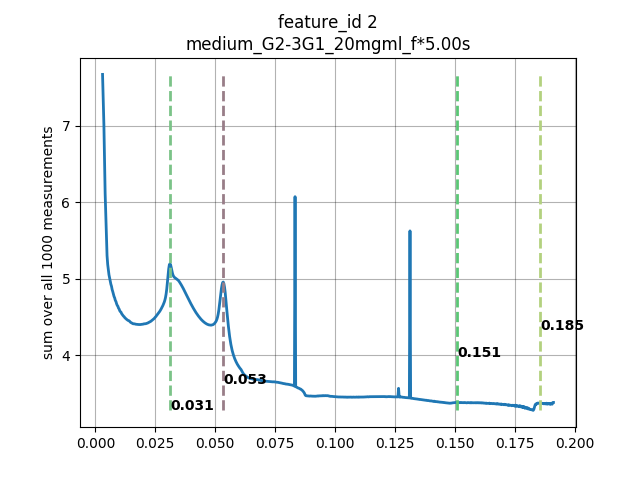

Peaks found at [0.031 0.053 0.151 0.185] for fit_prom 0.01


In [11]:
## Plot sum over all measurements
if feature_args['feature_id'] ==2:
    log10 = 1
    N_peaks = 10 ## Will find max. this number of peaks; Note the peak needs to be at least 2pixel wide
  
    line_x = np.asarray(features_map['info_map'][-1][0].x)
    line_y = np.zeros(line_x.shape)
    for idx, line in enumerate(features_map['info_map']):        
        line_y += np.asarray(line[0].y)
    if log10: line_y = np.log10(line_y)
    
    line = DataLine(x=line_x, y=line_y)
  
    plt.figure(98); plt.clf()
    plot_peaks(line, N_peaks, 1)
    plt.title('feature_id {}'.format(feature_args['feature_id'])+'\n'+'{}'.format(feature_args['filename']))
    plt.ylabel('sum over all {} measurements'.format((idx+1)))
    

#### Things below likely not working, ignore

<IPython.core.display.Javascript object>


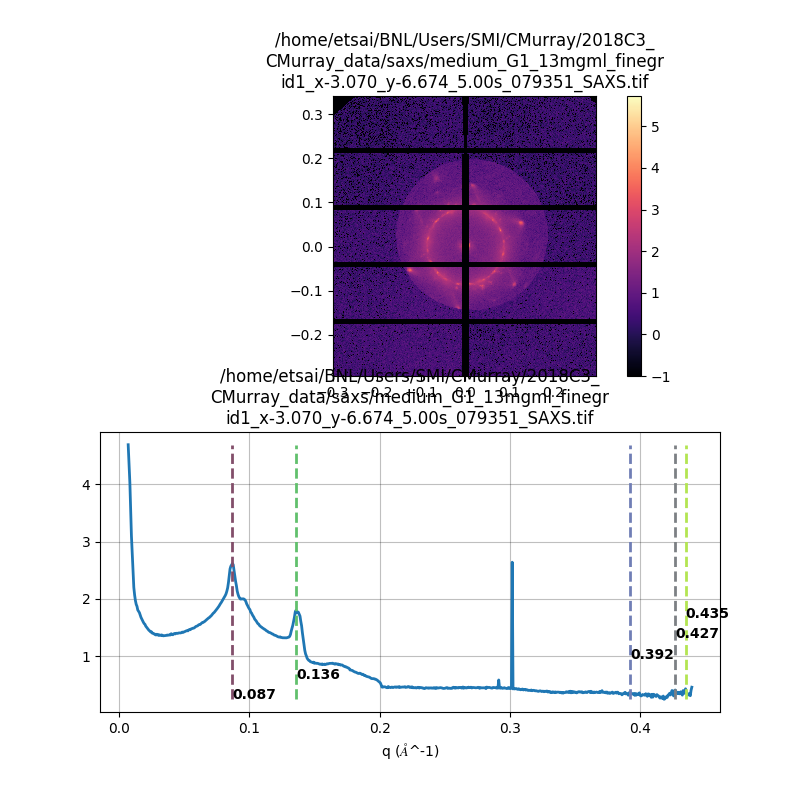

interactive(children=(IntSlider(value=1034, description='scan', max=2069), Output()), _dom_classes=('widget-in…

In [40]:
#### bqplot.heatmap
from bqplot import *
import bqplot.pyplot as bplt
from skimage import color
from fun_gui import *

%matplotlib nbagg
##### Slider for viewing all data
def slider_data(scan):      
    ## Plot one data 
    cmap = 'magma';  # 'viridis' 'magma' 'RdYlGn' 'RdYlBu' (https://matplotlib.org/examples/color/colormaps_reference.html)
    feature_args.update(cmap=cmap)
    feature_args['verbose'] = 1

    fdim = [2, 1]
    for idx in [1,2]:
        feature_args.update(feature_id=idx); 
        infiles, match_re = get_filematch(feature_args) 
        ax = plt.subplot2grid((fdim[0], fdim[1]), (idx-1, 0), colspan=1); ax.cla() 
        if infiles!=[]:
            plot_data(infiles[scan], **feature_args)  
    plt.show() 

%matplotlib nbagg
fig = plt.figure(10, figsize=[8,8]); plt.clf()
w = widgets.interactive(slider_data, scan=(0,len(infiles)-1))
w

In [39]:
def handle_slider_change(change):
    map1.color = color.rgb2gray(io.imread(infiles[change.new]))
    fig.title = infiles[change.new]+' - Scan'+str(change.new)

if feature_args['feature_id']==1:
    value_init = 0;
    img = color.rgb2gray(io.imread(infiles[value_init])); m, n = img.shape              
    x_sc, y_sc, c_sc, ax_x, ax_y, ax_c = bqplot_ax()
    map1 = bplt.heatmap(img, x=np.arange(1,m,1), y=np.arange(1,n,1), scales={'x': x_sc, 'y': y_sc, 'color': c_sc})

    fig = Figure(marks=[map1], animation_duration=100, axes=[ax_x,ax_y,ax_c])
    fig.title = infiles[value_init]
    fig.max_aspect_ratio = 1

    scan_slider = widgets.IntSlider(min=0, max=100, step=1, description='Scan', value=value_init)
    scan_slider.observe(handle_slider_change, 'value')

    play_button = widgets.Play(min=0, max=100, interval=1000)
    widgets.jslink((play_button, 'value'), (scan_slider, 'value'))
    widgets.VBox([widgets.HBox([play_button, scan_slider]), fig])
